In [15]:
import matplotlib.pyplot as plt   
import gzip
import numpy as np
%matplotlib inline

import time
import urllib
import os.path
import sys


In [16]:
# fold class for k-fold cross validation
class fold:
	def __init__(self, labels, data):
		self.labels = labels
		self.data = data
	def numpyerize(self):
		self.labels = np.array(self.labels)
		self.data = np.array(self.data)

In [17]:
folds = []

# set up data structure
for i in range(10):
	newfold = fold([[] for i in range(26)], [])
	folds.append(newfold)

# helper functions for converting to and from characters
def char_position(letter):
	return ord(letter) - 97
def char_from_num(num):
	return chr(num + 97)

# Dataset
f = open('letter.data', 'r')


# load data
for line in f.readlines():
	line = line.split("\t")

	# label
	letter = line[1]

	# fold
	foldnum = int(line[5])

	# one-hot encoding
	for i in range(26):
		folds[foldnum].labels[i].append(1 if char_position(letter) == i else -1)
	
	# features
	data = line[6:-1]
	datanew = [int(i.strip()) for i in data]
	folds[foldnum].data.append(datanew)

# set up for use with numpy
for i in range(10):
	folds[i].numpyerize()

	# add bias term
	folds[i].data = np.concatenate((np.ones((folds[i].data.shape[0], 1)), folds[i].data), axis=1)


In [18]:
def loglikelihood(w, X, y, alpha): 
    tmp = 1. + np.exp( -y * np.dot(w, X.T) )      
    prob = 1./tmp
    X = X.T 
    gradVal =   np.dot((  X * y ) ,  (tmp-1) * prob)  
    penalty = alpha/2.*np.sum(w[1:]**2.)  
    gradPenalty = -alpha * w             
    gradPenalty[0] = 0           
    return -np.sum( np.log( tmp ) ) - penalty, gradVal + gradPenalty

In [19]:
def gradient_ascent(f,x,init_step,iterations):  
    f_val,grad = f(x)                           
    f_vals = [f_val]
    for it in range(iterations):               
        done = False                            
        line_search_it = 0                     
        step = init_step                        
        while not done and line_search_it<100: 
            new_x = x + step*grad               
            new_f_val,new_grad = f(new_x)       
            if new_f_val<f_val:                 
                step = step*0.95                
                line_search_it += 1             
            else:
                done = True                    
        
        if not done:                           
            print("Line Search failed.")
        else:
            f_val = new_f_val                  
            x = new_x
            grad = new_grad
            f_vals.append(f_val)
        plt.plot(f_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Function value')
    return f_val, x

In [20]:
def optimizeFn( init_step, iterations, alpha, w, train_data, train_label):
    g = lambda xy0: loglikelihood(xy0, train_data, train_label, alpha)
    f_val, update_w = gradient_ascent( g, w, init_step, iterations )
    return f_val, update_w

o


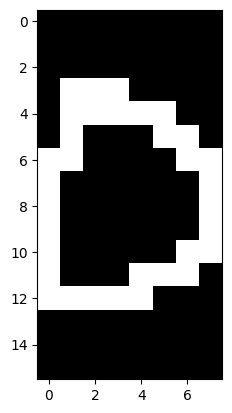

In [21]:
# Verify that the data is loaded correctly, should be a 'o'

binarydata = folds[0].data[0, 1:].reshape(16, 8)
for i in range(26):
	if folds[0].labels[i][0] == 1:
		print(char_from_num(i)) # should be 'o'
plt.imshow(binarydata, cmap='gray')
plt.show()

In [22]:
# Predict letter with the trained weights and an input letter (16,8) binary image
def predict(weights, data):
	probabilities = []
	for i in range(26): # 26 letters
		probabilities.append(1. / (1+np.exp(-np.dot(data, weights[i])))) # likelihood of each letter
	return np.argmax(probabilities) # return letter with max likelihood

# Use test data to validate the model
def validate(weights, data, labels):
	errors = 0
	for i in range(len(data)):
		prediction = predict(weights, data[i])
		if prediction != np.argmax(labels[:,i]):
			errors += 1
	return errors / len(data)

In [23]:
# Create dataset from folds, excluding the foldnum (-1 for all)
def create_dataset_from_folds(foldnum):
	train_labels = np.array([[] for i in range(26)])
	train_data = np.array([[] for i in range(16*8+1)]).T
	print(f'Creating dataset from fold {foldnum}, including: ', end='')
	if foldnum != -1:
		test_data = folds[foldnum].data
		test_labels = folds[foldnum].labels
	else:
		test_data = 0
		test_labels = 0
	for i in range(10):
		if i == foldnum:
			continue
		else:
			print(f'{i}, ', end='')
			train_data = np.concatenate((train_data, folds[i].data), axis = 0)
			train_labels = np.concatenate((train_labels, folds[i].labels), axis=1)
	
	print()
	return train_data, train_labels, test_data, test_labels

Creating dataset from fold 0, including: 1, 2, 3, 4, 5, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 0: 0.2618583495776478
Creating dataset from fold 1, including: 0, 2, 3, 4, 5, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 1: 0.27311627906976743
Creating dataset from fold 2, including: 0, 1, 3, 4, 5, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 2: 0.2622309197651663
Creating dataset from fold 3, including: 0, 1, 2, 4, 5, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 3: 0.2719970110218569
Creating dataset from fold 4, including: 0, 1, 2, 3, 5, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 4: 0.274573055028463
Creating dataset from fold 5, including: 0, 1, 2, 3, 4, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 5: 0.28114377124575085
Creating dataset from fold 6, including: 0, 1, 2, 3, 4, 5, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 6: 0.2873007343722013
Creating dataset from fold 7, including: 0, 1, 2, 3, 4, 5, 6, 8, 9, 
abcdefghijklmnopqrstuvwxyz
error 7: 0.2616387337057728
Creatin

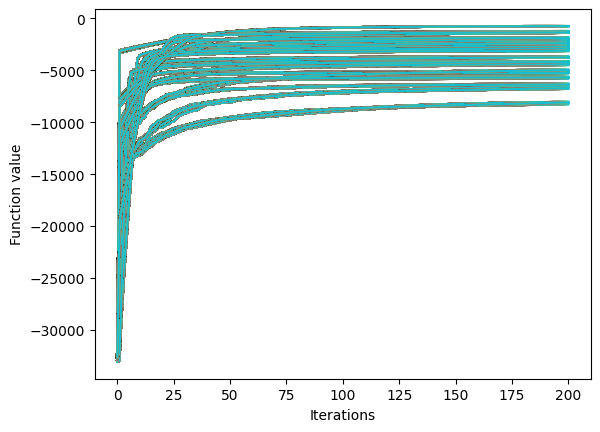

In [25]:
errors = []

# PARAMETERS #
init_step = 1e-4
iterations = 200
alpha = 50
##############

# 10-fold cross validation

for j in range(10):
	weights = []
	train_data, train_labels, test_data, test_labels = create_dataset_from_folds(j)
	for i in range(26):
		print(f'{char_from_num(i)}', end='')
		w_init = np.random.randn(train_data.shape[1]) * 0.001
		w_init[0] = 0
		

		f_val, update_w = optimizeFn(init_step, iterations, alpha, w = w_init, train_data = train_data, train_label = train_labels[i])
		weights.append(update_w)
	errors.append(validate(weights, data = test_data, labels = test_labels))
	print(f'\nerror {j}: {errors[-1]}')

In [26]:
# Calculate the CVError
print(f'CVError: {np.mean(errors)}')

CVError: 0.27276745510129724


Creating dataset from fold -1, including: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
abcdefghijklmnopqrstuvwxyz

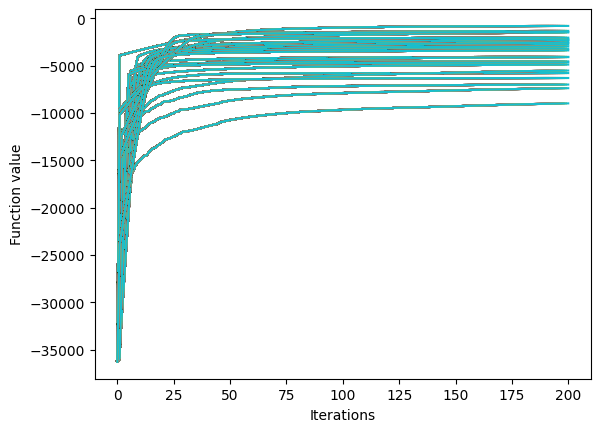

In [27]:
# Train on all data
weights = []
train_data, train_labels, _, _ = create_dataset_from_folds(-1)
for i in range(26):
	print(f'{char_from_num(i)}', end='')
	w_init = np.random.randn(train_data.shape[1]) * 0.001
	w_init[0] = 0

	f_val, update_w = optimizeFn(init_step, iterations, alpha, w = w_init, train_data = train_data, train_label = train_labels[i])
	weights.append(update_w)

['c', 'o', 'm', 'p', 'f', 'i', 'v', 'z', 's', 'i', 'x', 't', 'u', 'o']


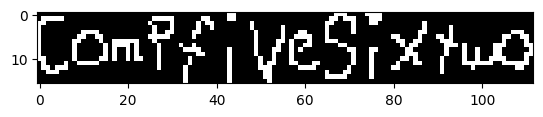

In [28]:

# Input letters
letters = []
#c
letters.append([1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
#o
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
#m
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
#p
letters.append([1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
# f
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,])
# i
letters.append([1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,])
# v
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,])
# e
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
# s
letters.append([1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,])
# i
letters.append([1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,])
# x
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
# t
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
# w
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])
# o
letters.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,])


letters = np.array(letters)

out_letters = []

for i in range(letters.shape[0]):
	out_letters.append(char_from_num(predict(weights, letters[i])))

print(out_letters)

out_image = letters[0][1:].reshape(16, 8)

for i in range(letters.shape[0] - 1):
	out_image = np.concatenate((out_image, letters[i+1][1:].reshape(16, 8)), axis=1)
	
plt.imshow(out_image, cmap='gray')
plt.show()